# 02_SOM_kmeans_process是为了通过SOM_kmeans实现找到最佳聚类数并且将不同聚类数的热岛数据可视化。

下面是具体的流程梳理:

#### 04采用了som进行特征值提取，然后采用kmeans进行聚类。
> 04_00 每次运行的时候都需要先运行的代码。
> 04_01 采用了som提取特征值，umatrix作为距离，kmeans聚类,得出K在K_range范围内的SSE箱型图图像。
> 04_02将scaled和original的数据存储到csv文件

#### 05 cluster重新排序，得到一个从大到小的sorted cluster的csv文件，并且计算sorted之后的cluster平均值。

#### 06 分析不同的cluster的热岛滑动平均数最终的图像

# 04_00 每次运行的时候都需要先运行的代码。

In [ ]:
import pandas as pd

# 读取 CSV 文件
d = pd.read_csv(r'D:\file\c_moving_average(MA)\223_cities_combined_moving_ave.csv')

# 调整 pandas 显示选项
pd.set_option('display.max_columns', None)  # 显示所有列
pd.set_option('display.width', 200)

# 打印前 5 行数据
print(d.head())

# 获取并打印行数和列数
print(f"Rows: {d.shape[0]}, Columns: {d.shape[1]}")

In [28]:
import numpy as np

# 文件路径
bmus_path = r'D:\file\new som\BMUs.npy'
weights_path = r'D:\file\new som\node_weights.npy'

# 加载 .npy 文件
bmus = np.load(bmus_path)
node_weights = np.load(weights_path)

# 打印基本信息
print("BMUs shape:", bmus.shape)
print("BMUs data:\n", bmus)

print("Node Weights shape:", node_weights.shape)
print("Node Weights data:\n", node_weights)

BMUs shape: (151348, 2)
BMUs data:
 [[10 30]
 [11 32]
 [11 33]
 ...
 [16 25]
 [16 25]
 [ 7 11]]
最大值 x: 16
最大值 y: 114
Node Weights shape: (1955, 2178)
Node Weights data:
 [[-0.98330384 -0.9240078  -0.88885856 ...  0.20108335  0.16854772
   0.18545485]
 [-0.93600696 -0.8845032  -0.8533882  ...  0.13780536  0.10844059
   0.12405691]
 [-0.88083285 -0.83834666 -0.8116631  ...  0.0645225   0.03888858
   0.0530978 ]
 ...
 [ 0.44286665  0.4361569   0.5762432  ... -2.1474385  -2.0907867
  -2.000168  ]
 [ 0.45089242  0.44392642  0.5827741  ... -2.2917802  -2.2231624
  -2.1304388 ]
 [ 0.46087408  0.4533271   0.5887083  ... -2.410287   -2.330998
  -2.2374897 ]]


# 04_01 采用了som提取特征值
对标准化后的数据逐点调用 som.winner，找到每个数据点映射到的最佳匹配神经元（BMU, Best Matching Unit）。
将结果转换为二维坐标数组 neuron_coords_flat，每个点对应一个 (x, y) 神经元坐标。

# 04_02将scaled和original的数据存储到csv文件
基于 SOM 输出的神经元坐标进行 K-means 聚类：
每个 K 值（即聚类数）运行一次聚类。
保存结果到 CSV 文件：分别保存基于标准化数据和原始数据的聚类结果。
自动化多次聚类任务：通过循环对不同的 K 值运行聚类分析，方便进行对比研究。

In [ ]:
import numpy as np
import pandas as pd
import os
from sklearn.cluster import KMeans

# 文件路径
bmus_path = r'D:\file\new som\BMUs.npy'
weights_path = r'D:\file\new som\node_weights.npy'
output_folder = r'D:\file\new som\results'
os.makedirs(output_folder, exist_ok=True)

# 加载 BMUs 和 Node Weights
bmus = np.load(bmus_path)
node_weights = np.load(weights_path)

# K-means 聚类函数
def kmeans_cluster_and_save(bmus, output_folder, K_range):
    for K in K_range:
        # 初始化并拟合 K-means 模型
        kmeans = KMeans(n_clusters=K, random_state=42)
        cluster_labels = kmeans.fit_predict(bmus)

        # 创建 DataFrame 保存聚类结果
        df = pd.DataFrame(bmus, columns=['BMU_X', 'BMU_Y'])
        df['Cluster'] = cluster_labels

        # 输出文件路径
        output_path = os.path.join(output_folder, f'bmus_kmeans_K{K}.csv')
        df.to_csv(output_path, index=False)
        print(f"K={K}: 结果已保存到 {output_path}")

# 设置 K 的范围
#K_range = [12, 15, 16, 17]
K_range=[11]
# 调用函数
kmeans_cluster_and_save(bmus, output_folder, K_range)


# 05 cluster重新排序，得到一个从大到小的sorted cluster的csv文件，并且计算sorted之后的cluster平均值。

In [ ]:
# import csv
# import pandas as pd
# import os
#
# def sort_clusters_and_save(input_file_path, output_file_path):
#     # 读取数据
#     df = pd.read_csv(input_file_path,encoding='gbk')
#
#     # 将 "X" 和 "Y" 列作为索引，这两列不需要进行聚类
#     df.set_index(["X", "Y"], inplace=True)
#     # 计算每个 Cluster 中除了 "X" 和 "Y" 列之外的其他列的平均值
#     cluster_means = df.groupby("Cluster").mean()
#
#     # 根据平均值排序 Cluster
#     sorted_clusters = cluster_means.mean(axis=1).sort_values().index
#
#     # 为每个 Cluster 分配新的编号
#     cluster_mapping = {cluster: new_cluster for new_cluster, cluster in enumerate(sorted_clusters, 0)}
#     # 更新 Cluster 列的值为新的编号
#     df["Cluster"] = df["Cluster"].map(cluster_mapping)
#
#     # 计算新的 Cluster 的总体均值并打印
#     new_cluster_means = df.groupby("Cluster").mean().mean(axis=1)
#     print(new_cluster_means)
#
#     # 保存更新后的 DataFrame
#     df.to_csv(output_file_path)
# def save_to_csv(data, labels, csv_filename, txt_filename):
#     with open(csv_filename, 'w', newline='') as csvfile:
#         writer = csv.writer(csvfile)
#
#         # 读取txt文件中的标题行
#         with open(txt_filename, 'r') as txtfile:
#             header = [title.strip() for title in txtfile.readlines()]
#
#         # 添加标签列名
#         header.append('Cluster')
#
#         # 写入标题行
#         writer.writerow(header)
#
#         # 写入数据行
#         for i in range(len(data)):
#             row_data = list(data[i])
#             # 填充缺少的温度值
#             num_temps = (len(row_data) - 2) // 2
#             while len(row_data) < num_temps * 2 + 2:
#                 row_data.append(None)
#             # 添加标签
#             row_data.append(labels[i])
#             # 写入数据行
#             writer.writerow(row_data)
#
# K_range=[12,15,16,17]
#
# for K in K_range:
#     output_folder=rf'..\..\04_som_try\{K}'
#     os.makedirs(output_folder, exist_ok=True)
#     #给cluster_scaled重新排序
#     cluster_origin_file_scaled=rf'..\..\04_som_try\{title}_clustered_som_kmeans_data(K={K})_scaled.csv'
#     cluster_processed_file_scaled=rf'..\..\04_som_try\{title}_sorted_clustered_som_kmeans_data(K={K})_scaled.csv'
#     # 保存数据到 CSV_scaled 文件
#     sort_clusters_and_save(cluster_origin_file_scaled, cluster_processed_file_scaled)
#     # 加载处理后的 DataFrame_scaled
#     cluster_processed_df_scaled = pd.read_csv(cluster_processed_file_scaled)
#     #根据Cluster_scaled重新排序
#     labels_scaled=cluster_processed_df_scaled["Cluster"]
#
#     #给cluster_original重新排序
#     cluster_origin_file_original=rf'..\..\04_som_try\{title}_clustered_som_kmeans_data(K={K})_original.csv'
#     cluster_processed_file_original=rf'..\..\04_som_try\{title}_sorted_clustered_som_kmeans_data(K={K})_original.csv'
#     # 保存数据到 CSV_original 文件
#     sort_clusters_and_save(cluster_origin_file_original, cluster_processed_file_original)
#     # 加载处理后的 DataFrame_original
#     cluster_processed_df_original = pd.read_csv(cluster_processed_file_original)
#     #根据Cluster_original重新排序
#     labels_original=cluster_processed_df_original["Cluster"]

In [ ]:
import numpy as np
import pandas as pd
import os
from sklearn.cluster import KMeans

# 文件路径
bmus_path = r'D:\file\new som\BMUs.npy'
weights_path = r'D:\file\new som\node_weights.npy'
output_folder = r'D:\file\new som\results'
os.makedirs(output_folder, exist_ok=True)

# 加载 BMUs 和 Node Weights
bmus = np.load(bmus_path)
node_weights = np.load(weights_path)

# K-means 聚类函数
def kmeans_cluster_and_save(bmus, output_folder, K_range):
    output_files = []
    for K in K_range:
        # 初始化并拟合 K-means 模型
        kmeans = KMeans(n_clusters=K, random_state=42)
        cluster_labels = kmeans.fit_predict(bmus)

        # 创建 DataFrame 保存聚类结果
        df = pd.DataFrame(bmus, columns=['BMU_X', 'BMU_Y'])
        df['Cluster'] = cluster_labels

        # 输出文件路径
        output_path = os.path.join(output_folder, f'bmus_kmeans_K{K}.csv')
        df.to_csv(output_path, index=False)
        print(f"K={K}: 聚类结果已保存到 {output_path}")
        output_files.append(output_path)
    return output_files

# Cluster 排序函数
def sort_clusters_and_save(input_file_path, output_file_path):
    # 读取数据
    df = pd.read_csv(input_file_path)

    # 计算每个 Cluster 的 BMU 坐标均值
    cluster_means = df.groupby("Cluster")[["BMU_X", "BMU_Y"]].mean()

    # 根据均值排序 Cluster
    sorted_clusters = cluster_means.mean(axis=1).sort_values().index

    # 为每个 Cluster 分配新的编号
    cluster_mapping = {cluster: new_cluster for new_cluster, cluster in enumerate(sorted_clusters, 0)}
    # 更新 Cluster 列的值为新的编号
    df["Cluster"] = df["Cluster"].map(cluster_mapping)

    # 打印新的 Cluster 的均值
    new_cluster_means = df.groupby("Cluster")[["BMU_X", "BMU_Y"]].mean()
    print(f"重新编号后的 Cluster 均值：\n{new_cluster_means}")

    # 保存更新后的 DataFrame
    df.to_csv(output_file_path, index=False)
    print(f"排序后的结果已保存到 {output_file_path}")

# 设置 K 的范围
K_range = [11]

# 调用聚类函数
clustered_files = kmeans_cluster_and_save(bmus, output_folder, K_range)

# 对每个文件进行排序并保存
for input_file in clustered_files:
    sorted_output_file = input_file.replace(".csv", "_sorted.csv")
    sort_clusters_and_save(input_file, sorted_output_file)


In [ ]:
import pandas as pd

# 读取 CSV 文件
file_path = r'D:\file\new som\results\bmus_kmeans_K11_sorted.csv'
df = pd.read_csv(file_path)

d_path = r'D:\file\c_moving_average(MA)\223_cities_combined_moving_ave.csv'
d = pd.read_csv(d_path)

# 将 df['Cluster'] 写入 d 的最后一列
d['cluster'] = df['Cluster'].values

# 保存结果到一个新的 CSV 文件
output_path = r'D:\file\223_cities_combined_moving_ave_cluster.csv'
d.to_csv(output_path, index=False)

print(f"已保存到: {output_path}")


# 06 分析不同的cluster的热岛滑动平均数最终的图像
分析不同聚类的热岛滑动平均数，并检查数据中是否存在NaN或Inf值。
清除异常值并生成最终的可视化图像。

In [ ]:
d_path =pd.read_csv(r'D:\file\c_moving_average(MA)\223_cities_combined_moving_ave.csv')

In [ ]:
# 读取 CSV 文件
d = pd.read_csv(r'D:\file\223_cities_combined_moving_ave_cluster.csv')

                   X             Y  gf_Day2017_001_to_gf_Day2017_007  \
0       3.679990e+05  5.108440e+06                          0.421664   
3       3.718085e+05  5.108440e+06                          0.821664   
11      3.727608e+05  5.103691e+06                          0.550235   
12      3.737132e+05  5.103691e+06                          0.564521   
33      3.965699e+05  5.098942e+06                          0.678807   
...              ...           ...                               ...   
151325 -5.289757e+06 -3.887020e+06                          0.969388   
151342 -5.279140e+06 -3.888004e+06                          1.297959   
151344 -5.283966e+06 -3.888989e+06                          2.340816   
151345 -5.283000e+06 -3.888989e+06                          2.612245   
151346 -5.282035e+06 -3.888989e+06                          2.612245   

        gf_Day2017_002_to_gf_Day2017_008  gf_Day2017_003_to_gf_Day2017_009  \
0                               0.484929                 

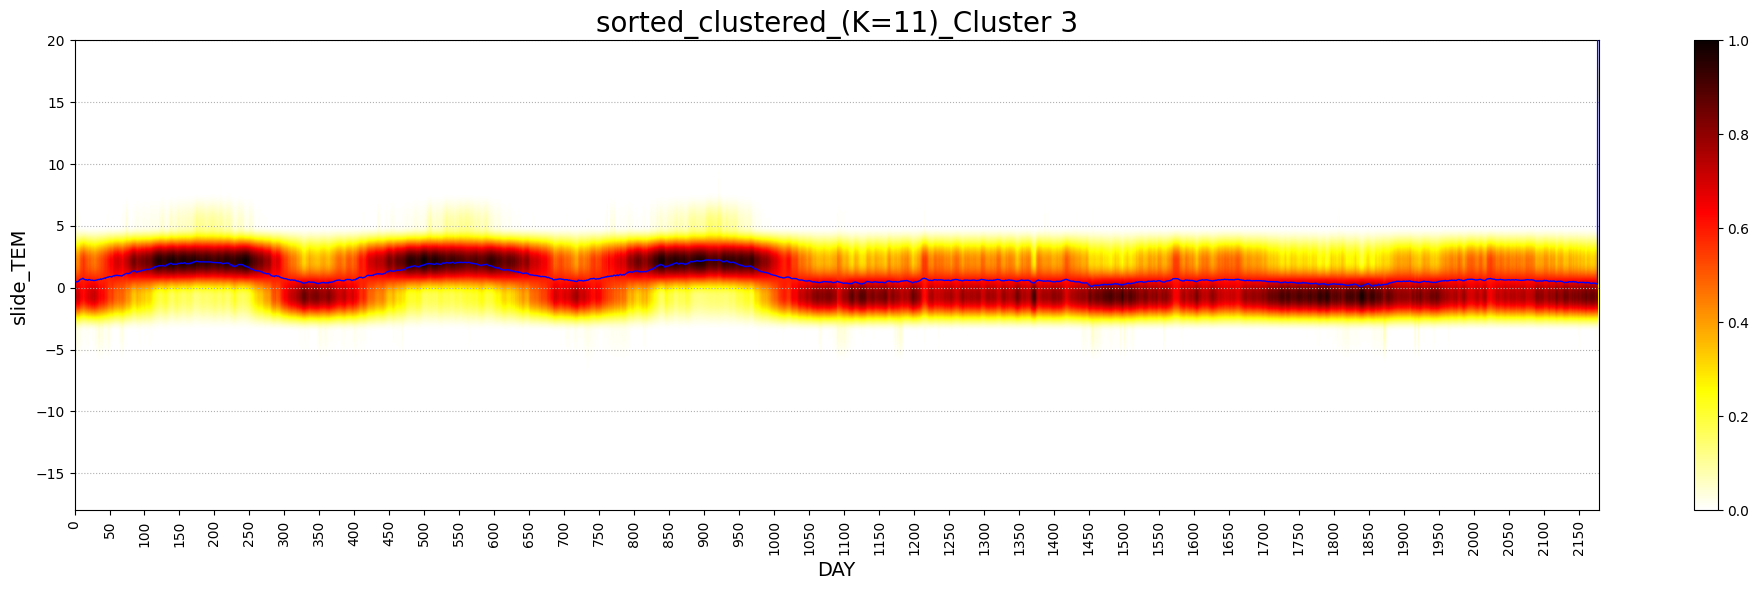

                   X             Y  gf_Day2017_001_to_gf_Day2017_007  \
1       3.689514e+05  5.108440e+06                          0.807378   
2       3.699037e+05  5.108440e+06                          0.921664   
5       3.718085e+05  5.107490e+06                          0.493093   
15      3.727608e+05  5.102741e+06                          0.821664   
16      3.737132e+05  5.102741e+06                          0.593093   
...              ...           ...                               ...   
151337 -5.283966e+06 -3.888004e+06                          2.940816   
151338 -5.283000e+06 -3.888004e+06                          3.426531   
151339 -5.282035e+06 -3.888004e+06                          3.283673   
151340 -5.281070e+06 -3.888004e+06                          2.197959   
151341 -5.280105e+06 -3.888004e+06                          1.855102   

        gf_Day2017_002_to_gf_Day2017_008  gf_Day2017_003_to_gf_Day2017_009  \
1                               0.913501                 

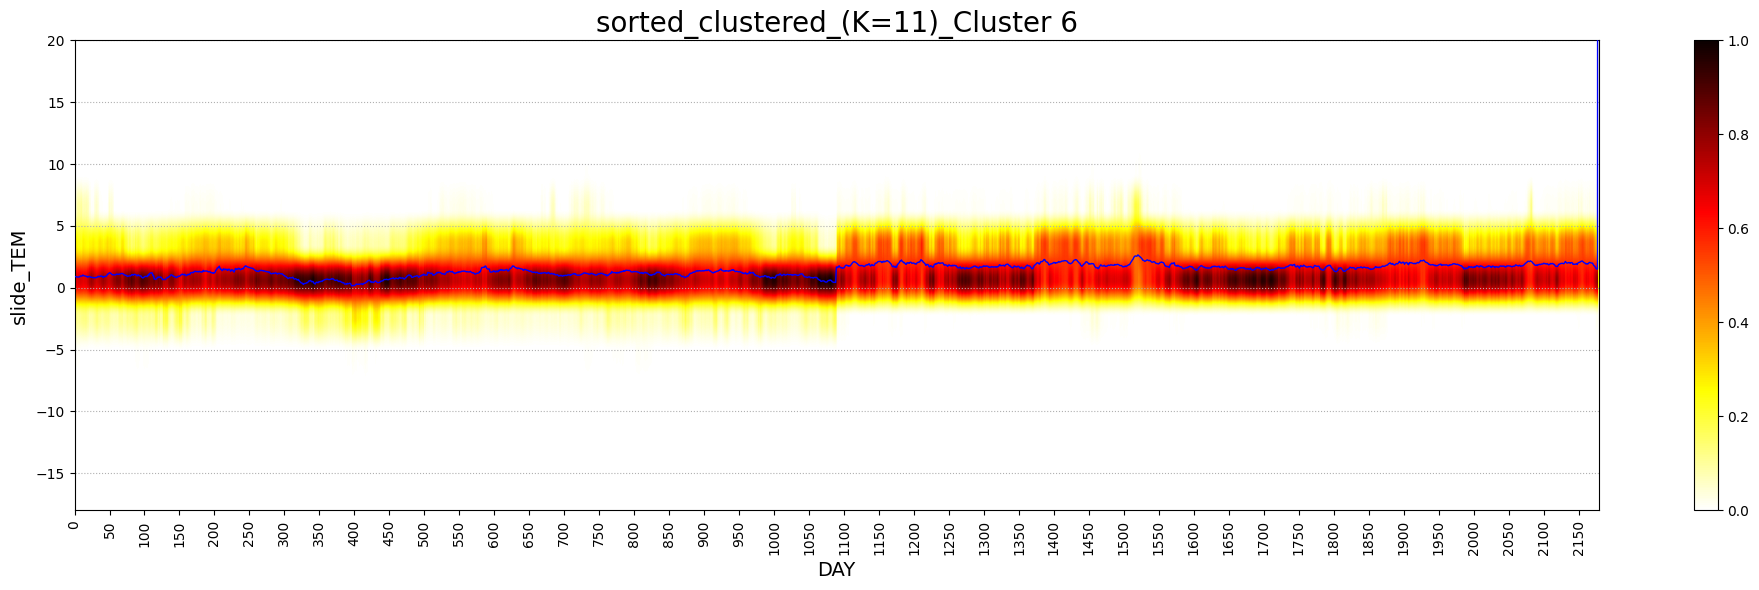

                   X             Y  gf_Day2017_001_to_gf_Day2017_007  \
4       3.727608e+05  5.108440e+06                         -0.092622   
6       3.727608e+05  5.107490e+06                          0.493093   
7       3.727608e+05  5.106540e+06                         -0.035479   
8       3.727608e+05  5.105590e+06                          0.078807   
9       3.727608e+05  5.104641e+06                          0.593093   
...              ...           ...                               ...   
151268 -5.280105e+06 -3.882097e+06                          0.655102   
151294 -5.276244e+06 -3.884066e+06                          0.526531   
151324 -5.290722e+06 -3.887020e+06                          0.369388   
151343 -5.276244e+06 -3.888004e+06                          0.326531   
151347 -5.283000e+06 -3.889974e+06                          1.597959   

        gf_Day2017_002_to_gf_Day2017_008  gf_Day2017_003_to_gf_Day2017_009  \
4                              -0.029356                 

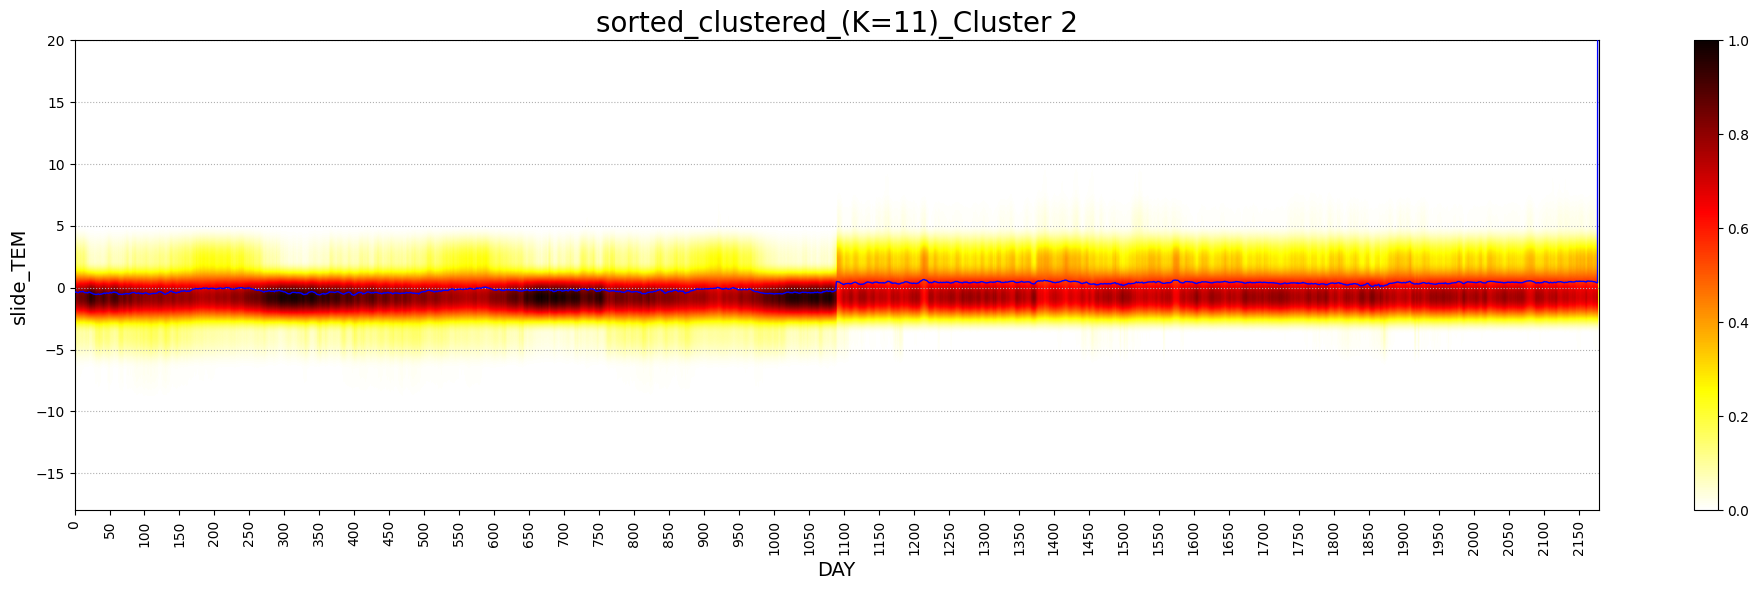

                   X             Y  gf_Day2017_001_to_gf_Day2017_007  \
42      3.918081e+05  5.097992e+06                          0.350235   
43      3.927605e+05  5.097992e+06                         -0.092622   
44      3.965699e+05  5.097992e+06                          0.750235   
66      3.870463e+05  5.096092e+06                          0.450235   
67      3.879987e+05  5.096092e+06                         -0.049765   
...              ...           ...                               ...   
148702  2.972818e+06 -3.338472e+06                          2.997619   
148709  2.969021e+06 -3.339414e+06                          1.097619   
148710  2.969970e+06 -3.339414e+06                          2.183333   
148711  2.970919e+06 -3.339414e+06                          2.669048   
148712  2.971869e+06 -3.339414e+06                          3.111905   

        gf_Day2017_002_to_gf_Day2017_008  gf_Day2017_003_to_gf_Day2017_009  \
42                              0.227786                 

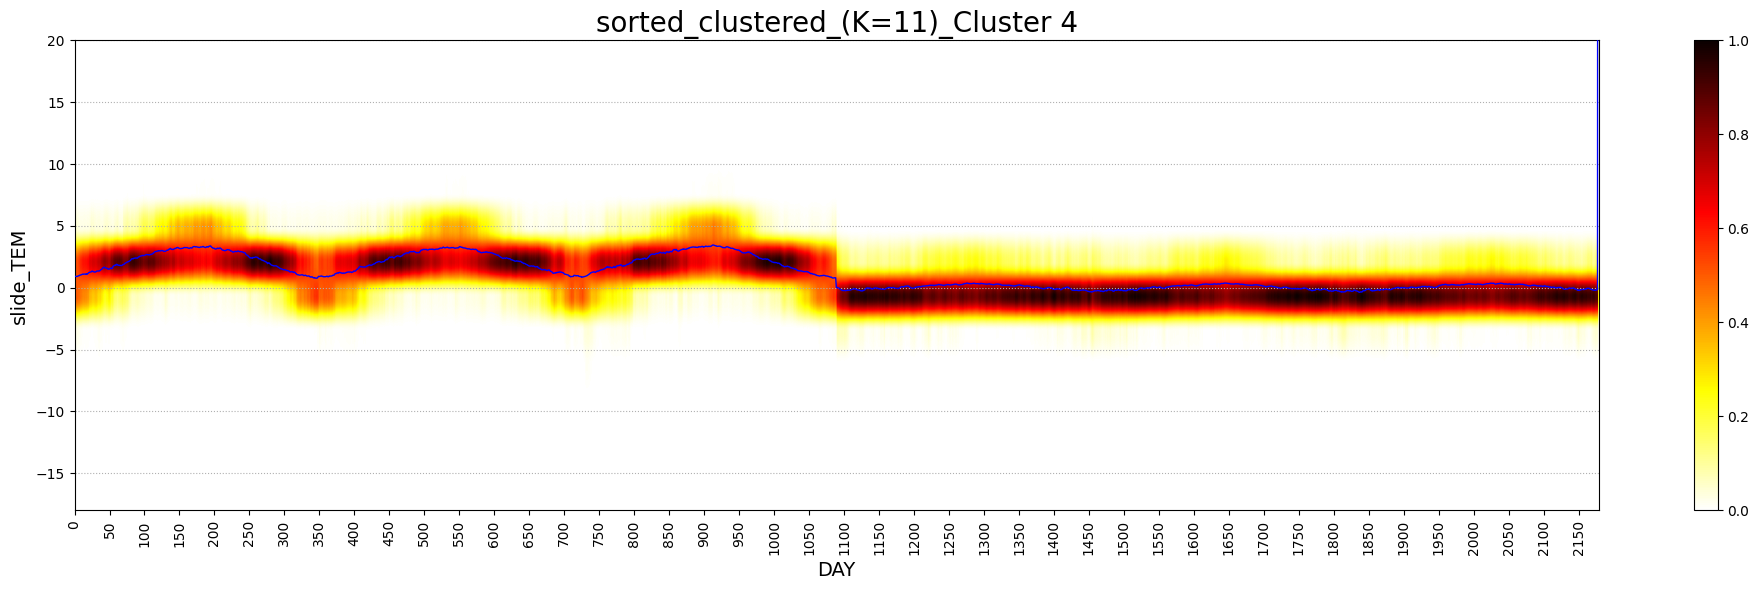

                   X             Y  gf_Day2017_001_to_gf_Day2017_007  \
57      3.956176e+05  5.097042e+06                         -0.306907   
69      3.956176e+05  5.096092e+06                         -0.521193   
211     3.946652e+05  5.089444e+06                         -0.335479   
344     3.641895e+05  5.083745e+06                         -0.864050   
368     3.641895e+05  5.082795e+06                         -0.792622   
...              ...           ...                               ...   
148763  2.967122e+06 -3.347898e+06                         -1.073810   
150987 -5.139962e+06 -3.857542e+06                          2.017641   
150991 -5.137096e+06 -3.859461e+06                          1.417641   
151009 -5.126584e+06 -3.870018e+06                          0.617641   
151010 -5.125629e+06 -3.870018e+06                          0.731926   

        gf_Day2017_002_to_gf_Day2017_008  gf_Day2017_003_to_gf_Day2017_009  \
57                             -0.429356                 

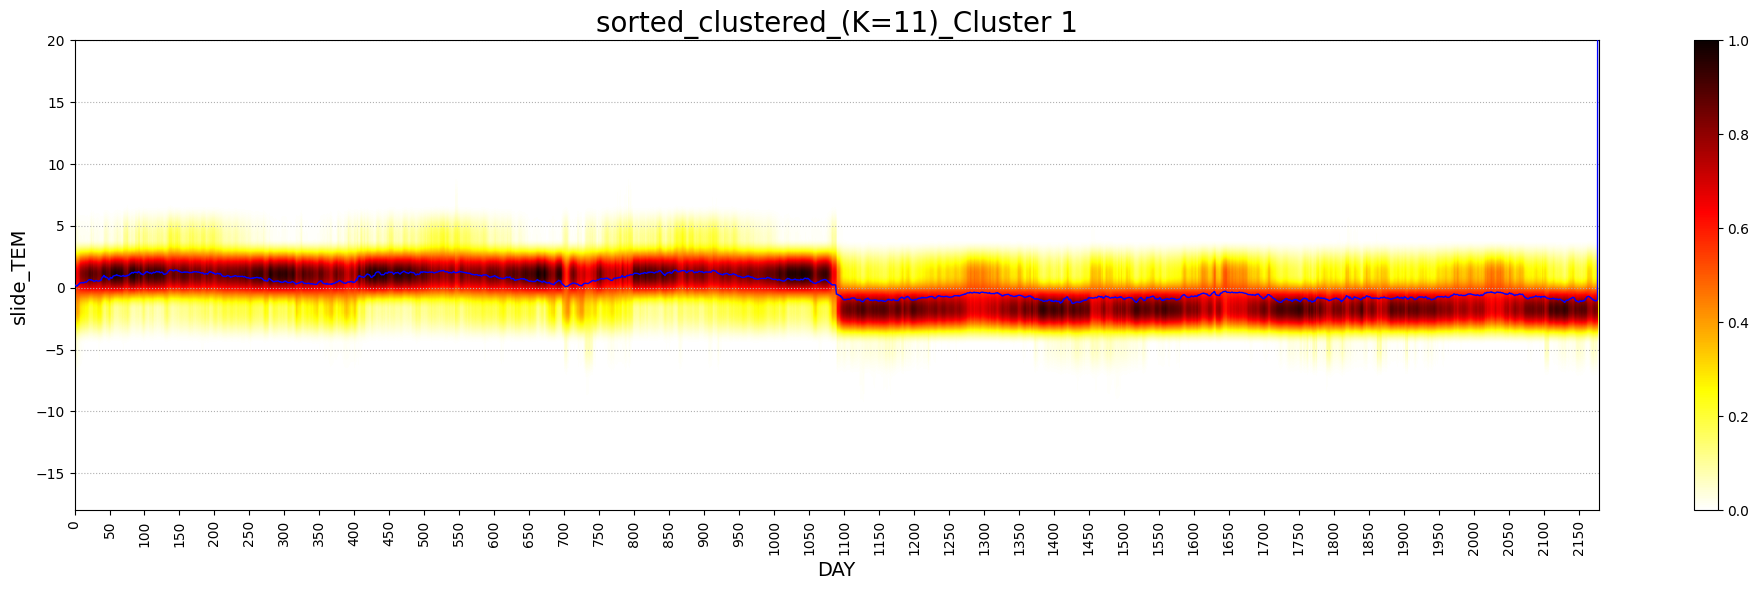

                   X             Y  gf_Day2017_001_to_gf_Day2017_007  \
97      3.784750e+05  5.094193e+06                          0.378807   
175     3.813321e+05  5.090394e+06                          1.064521   
176     3.822845e+05  5.090394e+06                          1.235950   
183     3.899034e+05  5.090394e+06                          1.035950   
196     3.775226e+05  5.089444e+06                          1.178807   
...              ...           ...                               ...   
146960 -4.931067e+06 -3.294166e+06                          5.323204   
147004 -4.937691e+06 -3.297925e+06                          3.066061   
147130 -4.933906e+06 -3.309201e+06                          2.580347   
147174 -4.936745e+06 -3.316719e+06                          3.766061   
147181 -4.936745e+06 -3.317658e+06                          2.951775   

        gf_Day2017_002_to_gf_Day2017_008  gf_Day2017_003_to_gf_Day2017_009  \
97                              0.299215                 

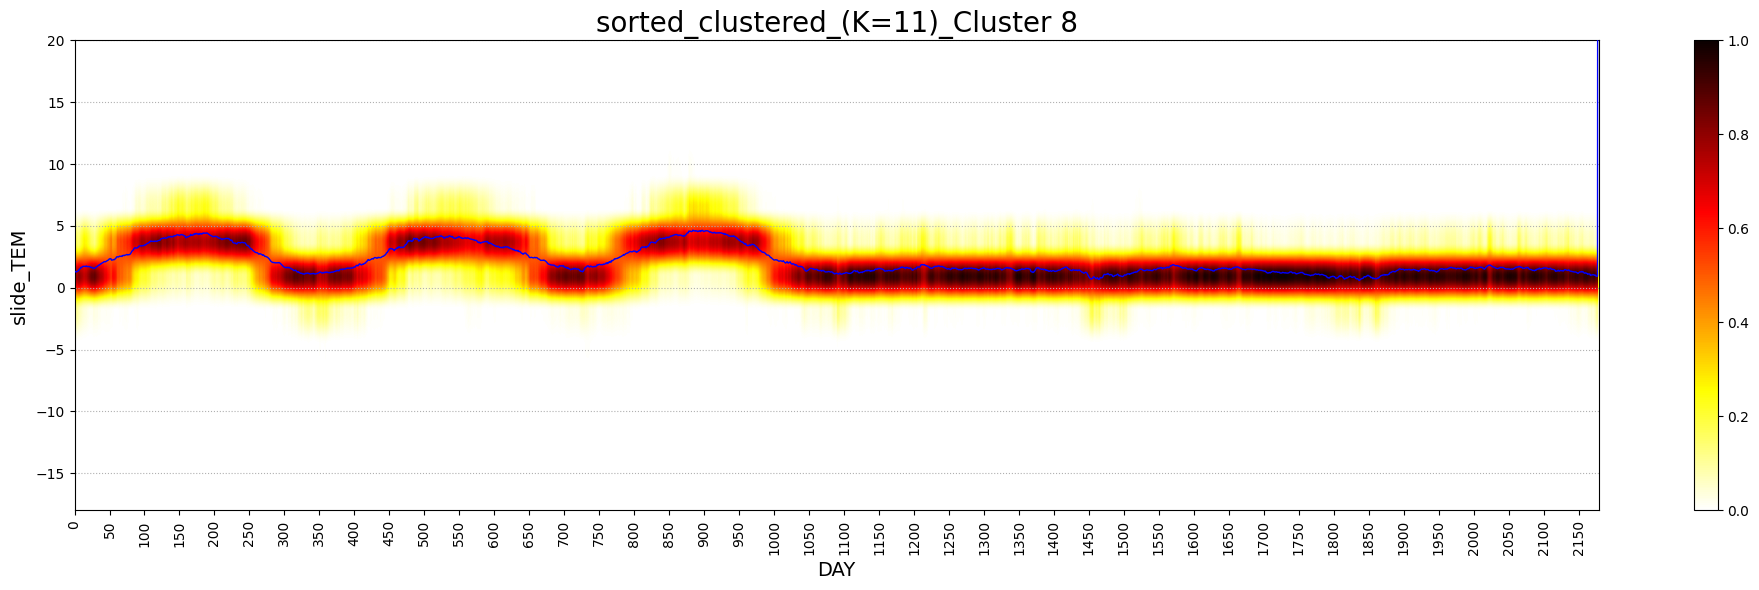

                   X             Y  gf_Day2017_001_to_gf_Day2017_007  \
209     3.899034e+05  5.089444e+06                          0.750235   
259     3.813321e+05  5.087544e+06                          1.321664   
260     3.822845e+05  5.087544e+06                          1.178807   
285     3.813321e+05  5.086594e+06                          0.693093   
286     3.822845e+05  5.086594e+06                          1.050235   
...              ...           ...                               ...   
142465  1.130811e+07  2.512499e+06                          3.735714   
142466  1.130907e+07  2.512499e+06                          2.935714   
142472  1.130715e+07  2.511526e+06                          4.321429   
142473  1.130811e+07  2.511526e+06                          3.750000   
142474  1.130907e+07  2.511526e+06                          3.378571   

        gf_Day2017_002_to_gf_Day2017_008  gf_Day2017_003_to_gf_Day2017_009  \
209                             0.684929                 

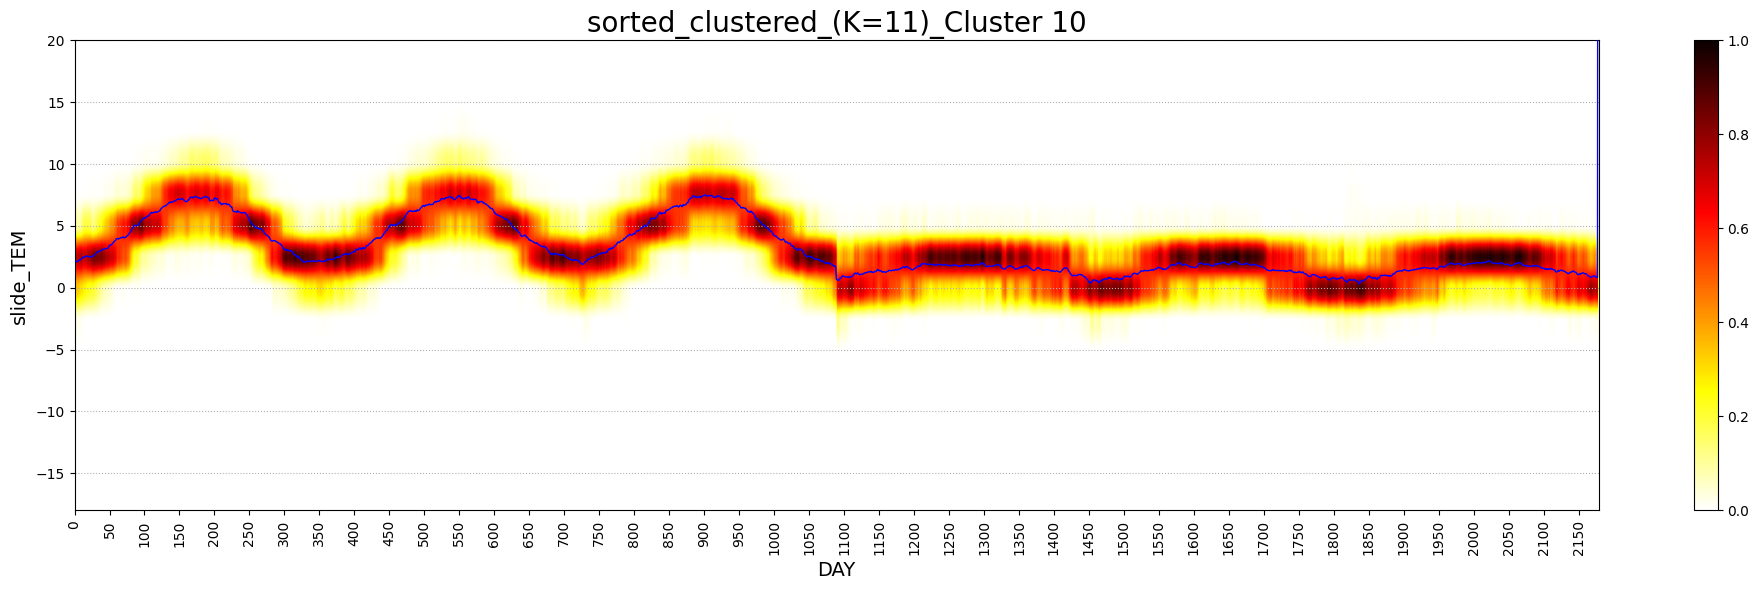

                   X             Y  gf_Day2017_001_to_gf_Day2017_007  \
210     3.908558e+05  5.089444e+06                          0.378807   
235     3.889510e+05  5.088494e+06                          0.178807   
236     3.899034e+05  5.088494e+06                          1.864521   
237     3.908558e+05  5.088494e+06                          0.235950   
261     3.832368e+05  5.087544e+06                          1.050235   
...              ...           ...                               ...   
142471  1.130619e+07  2.511526e+06                          3.264286   
142479  1.130619e+07  2.510553e+06                          2.921429   
142480  1.130715e+07  2.510553e+06                          2.492857   
142481  1.130811e+07  2.510553e+06                          3.135714   
142486  1.130619e+07  2.509580e+06                          1.664286   

        gf_Day2017_002_to_gf_Day2017_008  gf_Day2017_003_to_gf_Day2017_009  \
210                             0.313501                 

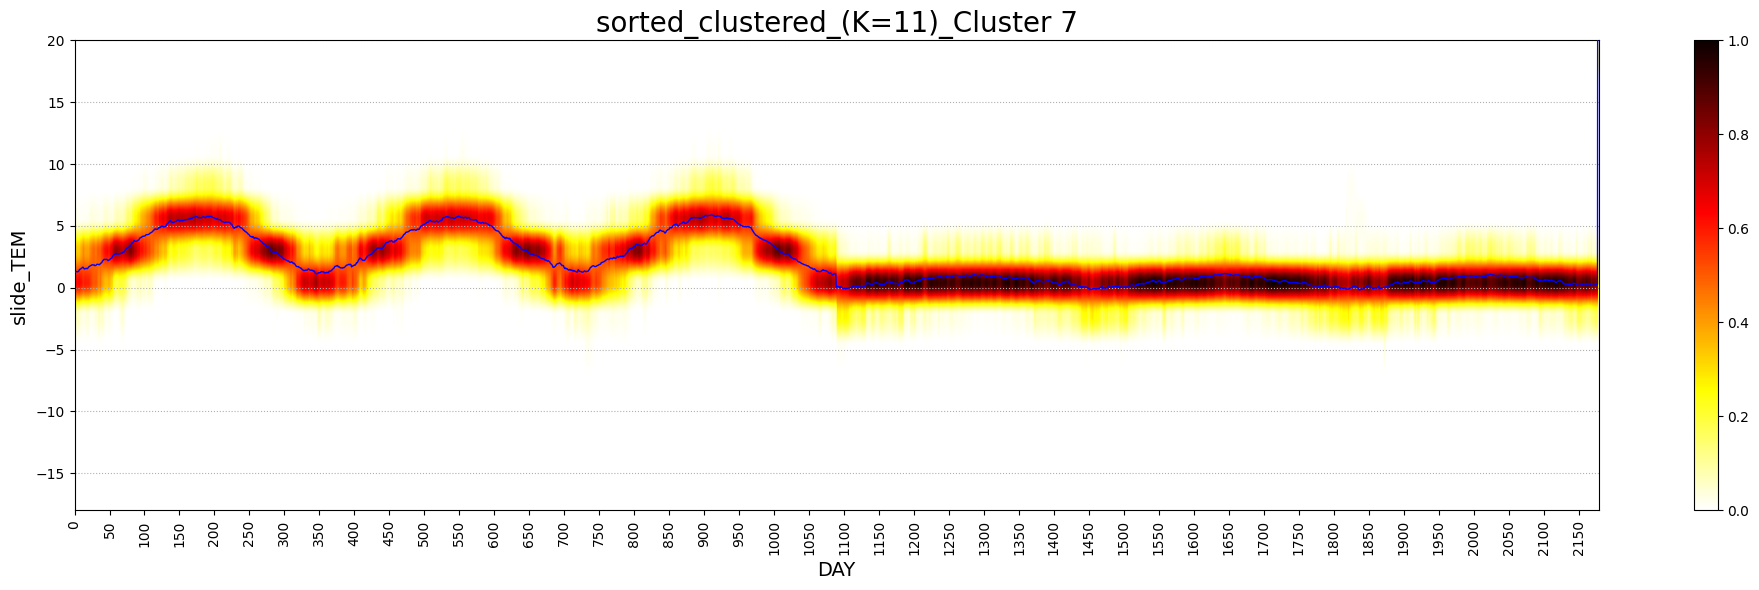

                   X             Y  gf_Day2017_001_to_gf_Day2017_007  \
856     7.672092e+05  5.092685e+06                         -2.345238   
2460    7.907093e+05  5.080654e+06                         -2.371429   
2461    7.926288e+05  5.076815e+06                         -1.400000   
2462    7.926288e+05  5.075856e+06                         -1.800000   
2463    7.926288e+05  5.074896e+06                         -1.828571   
...              ...           ...                               ...   
141749  1.109190e+07  2.549147e+06                         -2.267857   
141751  1.109001e+07  2.548189e+06                         -2.367857   
142055  1.111835e+07  2.535741e+06                         -4.639286   
142089  1.111929e+07  2.534784e+06                         -3.253571   
142145  1.110796e+07  2.532869e+06                         -9.825000   

        gf_Day2017_002_to_gf_Day2017_008  gf_Day2017_003_to_gf_Day2017_009  \
856                            -2.498571                 

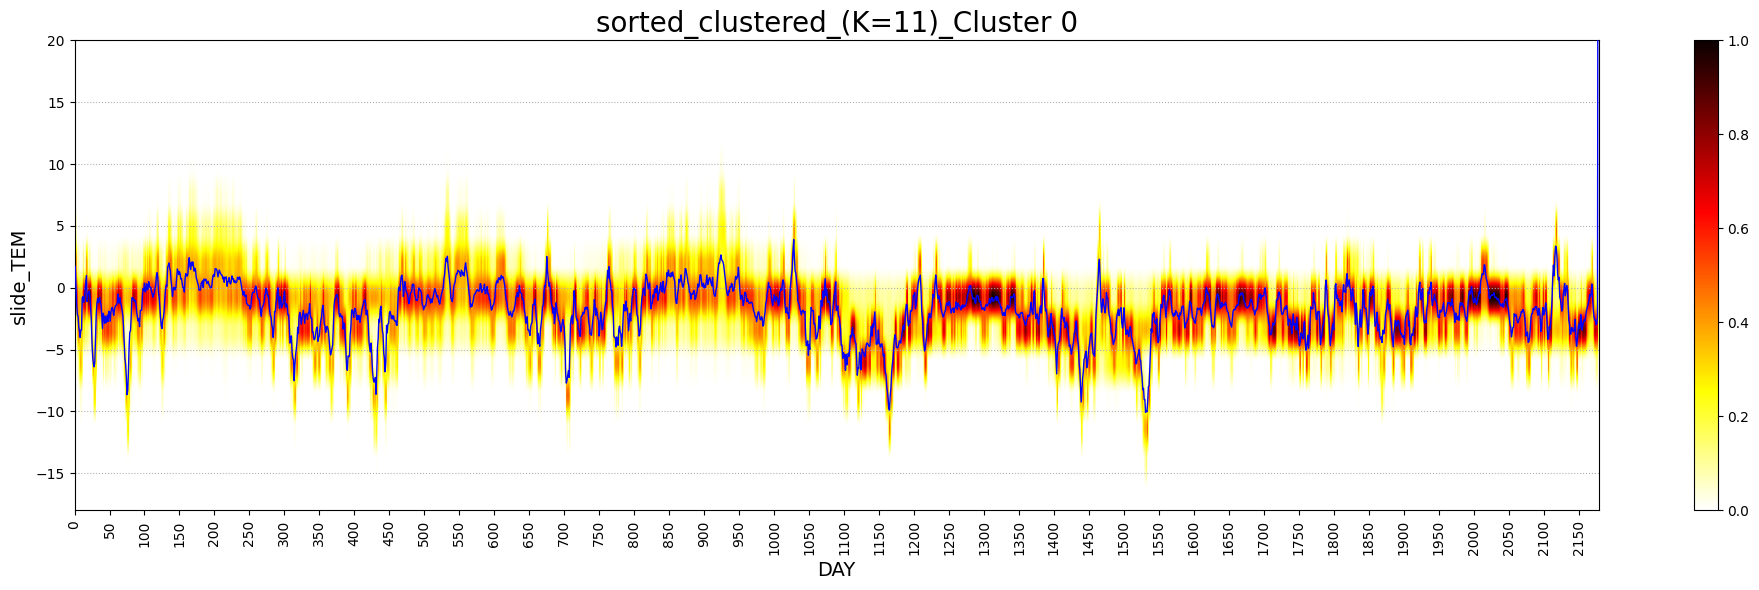

                   X             Y  gf_Day2017_001_to_gf_Day2017_007  \
870     7.045106e+05  5.090800e+06                         -0.230952   
876     6.998316e+05  5.089858e+06                         -0.588095   
877     7.017032e+05  5.089858e+06                         -0.102381   
878     7.026390e+05  5.089858e+06                         -0.045238   
879     7.035748e+05  5.089858e+06                         -0.230952   
...              ...           ...                               ...   
142326  1.111362e+07  2.525209e+06                          7.346429   
142327  1.111457e+07  2.525209e+06                          0.089286   
142336  1.111646e+07  2.523294e+06                          0.860714   
142339  1.111740e+07  2.522336e+06                         -2.410714   
142340  1.111835e+07  2.522336e+06                          1.103571   

        gf_Day2017_002_to_gf_Day2017_008  gf_Day2017_003_to_gf_Day2017_009  \
870                            -0.355714                 

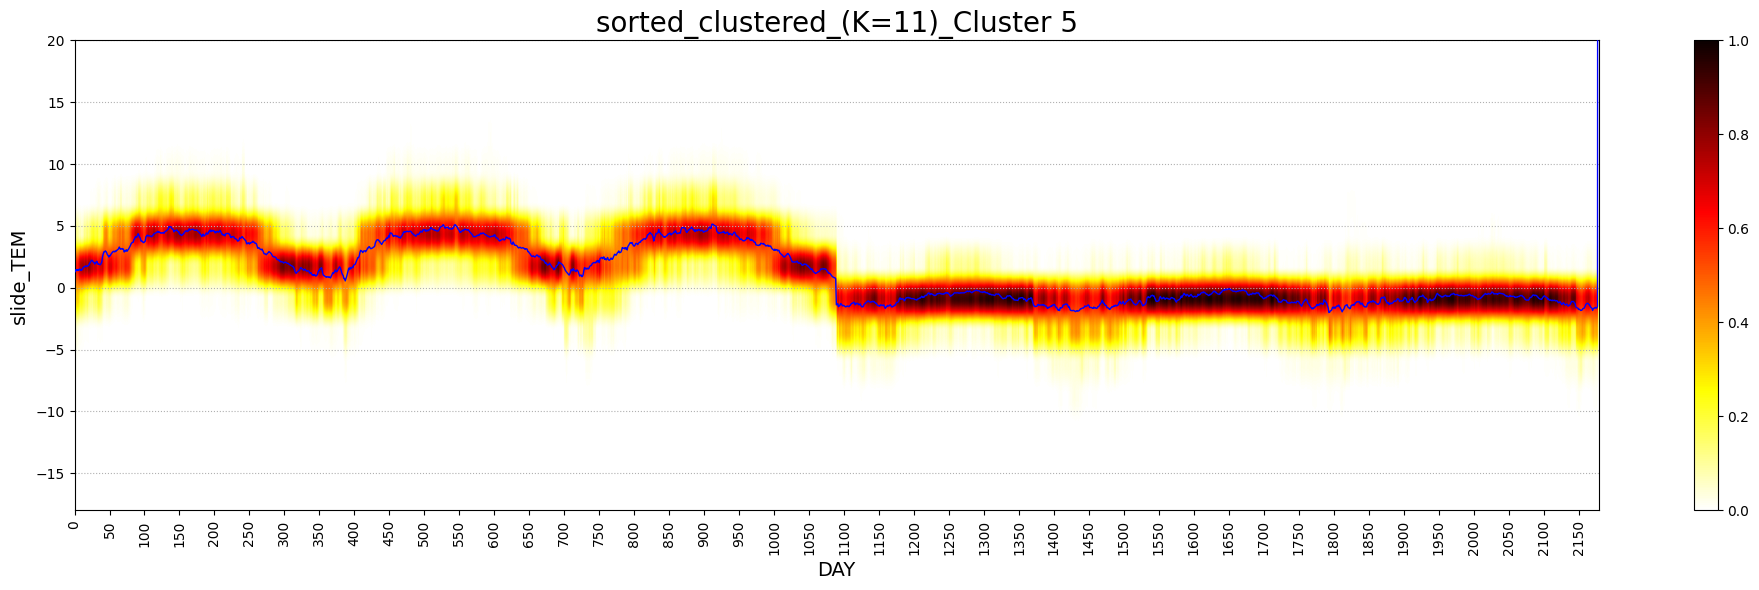

                   X             Y  gf_Day2017_001_to_gf_Day2017_007  \
71938  -7.464414e+06  3.665274e+06                          2.446406   
89407   1.159197e+07  3.462183e+06                         11.686204   
97596   1.156013e+07  3.357392e+06                          1.684764   
103029 -8.739591e+06  3.377992e+06                          3.168283   
103045 -8.739591e+06  3.377044e+06                          3.525425   
...              ...           ...                               ...   
148626  2.978513e+06 -3.333759e+06                          4.040476   
148644  2.978513e+06 -3.334701e+06                          3.726190   
149074 -5.383512e+06 -3.829923e+06                          7.212478   
149075 -5.382576e+06 -3.829923e+06                          6.969621   
149101 -5.382576e+06 -3.830863e+06                          4.869621   

        gf_Day2017_002_to_gf_Day2017_008  gf_Day2017_003_to_gf_Day2017_009  \
71938                           2.710055                 

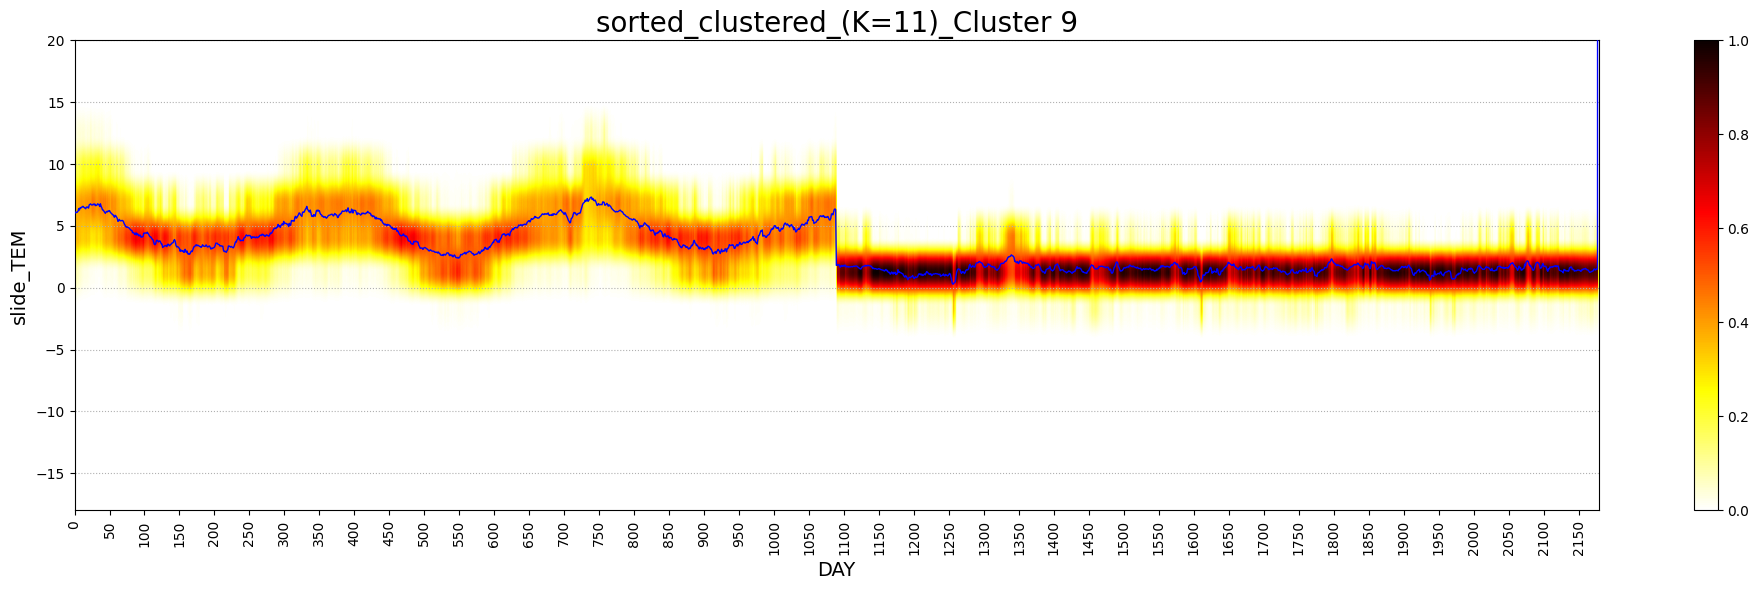

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from pydlc import dense_lines
import numpy as np

def plot_cluster_data(file_path, K, output_folder):
    # 读取CSV文件
    data = pd.read_csv(file_path)

    # # 检查并清除包含 NaN 或 Inf 值的行
    # if np.isnan(data.values).any() or np.isinf(data.values).any():
    #     # 打印包含 NaN 和 Inf 值的行
    #     print("原始数据框包含 NaN 或 Inf 值：")
    #     print(data)
    #
    #     # 打印 NaN 和 Inf 值的位置
    #     nan_mask = np.isnan(data.values)
    #     inf_mask = np.isinf(data.values)
    #
    #     nan_positions = np.where(nan_mask)
    #     inf_positions = np.where(inf_mask)
    #
    #     if len(nan_positions[0]) > 0:
    #         print("NaN 值及其位置：")
    #         for row, col in zip(nan_positions[0], nan_positions[1]):
    #             print(f"NaN 值在行 {row}, 列 {col}")
    #
    #     if len(inf_positions[0]) > 0:
    #         print("Inf 值及其位置：")
    #         for row, col in zip(inf_positions[0], inf_positions[1]):
    #             print(f"Inf 值在行 {row}, 列 {col}")
    #
    #     # 删除包含 NaN 或 Inf 值的行
    #     data = data.dropna().replace([np.inf, -np.inf], np.nan).dropna()
    #
    #     # 打印清理后的数据框
    #     print("清理后的数据框：\ndata")
    # else:
    #     print("数据框中不包含 NaN 或 Inf 值。")

    # 获取所有的 cluster 值
    clusters = data['Cluster'].unique()

    # 遍历每个 cluster
    for cluster in clusters:
        # 筛选出当前 cluster 的数据
        cluster_data = data[data['Cluster'] == cluster]
        print(cluster_data)
        cluster_data_to_plot = cluster_data.iloc[:, 2:-4]

        # 创建图表
        fig, ax = plt.subplots(figsize=(20, 6))
        fig.patch.set_facecolor('white')  # 设置图形背景为白色
        ax.set_facecolor('white')  # 设置轴背景为白色

        # 获取列数
        columns = np.arange(cluster_data_to_plot.shape[1])

        # 绘制中值折线图
        ax.plot(columns, cluster_data_to_plot.median(), linestyle='-', color='b', label='Median', linewidth=1, zorder=10)

        # 使用 dense_lines 绘制密度线图
        im = dense_lines(cluster_data_to_plot.values, x=columns, ax=ax, cmap='hot_r')
        fig.colorbar(im, ax=ax)

        # 设置图表布局和标题
        ax.set_title(f'sorted_clustered_(K={K})_Cluster {cluster}', fontsize=20)
        ax.set_xlabel('DAY', fontsize=14)
        ax.set_ylabel('slide_TEM', fontsize=14)

        # 删除竖直网格线
        ax.grid(which='major', axis='y', linestyle='dotted')

        ax.set_ylim(-18, 20)  # 纵坐标是-100到100

        # 设置 X 轴刻度和标签
        ax.set_xticks(columns[::50])  # 每隔50个数据点设置一个刻度
        ax.set_xticklabels(columns[::50])  # 设置对应刻度的标签为 columns 数组中的值

        # 旋转 x 轴标签，避免重叠
        plt.xticks(rotation=90)

        # 设置 x 轴范围，保证宽度匹配 figsize=(20, 6)
        ax.set_xlim(0, len(columns))  # 设置 x 轴范围为 0 到总列数

        # 调整布局，确保图像居中显示
        plt.tight_layout()

        # 保存图像为 JPG 格式
        os.makedirs(output_folder, exist_ok=True)
        output_file = os.path.join(output_folder, rf'sorted_clustered_som_kmeans_data(K={K})_{cluster}.jpg')
        plt.savefig(output_file, format='jpg', dpi=100, bbox_inches='tight')

        # 显示图表
        plt.show()

K_range=[11]

for K in K_range:
    # 调用函数示例
    file_path = rf'D:\file\d_som\223_cities_combined_moving_ave_cluster_sort.csv'
    output_folder = rf'D:\file\d_som\results\picture\K={K}'
    # 创建输出文件所在的目录
    os.makedirs(output_folder, exist_ok=True)

    plot_cluster_data(file_path, K, output_folder)